# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet

/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump-tweet-analysis/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
/Users/AHurt/.virtualenvs/trump

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [10]:
# response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
# z = zipfile.ZipFile(io.BytesIO(response.content))
# z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

Source data pulled from: http://www.trumptwitterarchive.com/archive
- Time span: 1/20/2017 to 8/31/2018
- Click button to export JSON, which basically just fills in a textarea above the search interface. Copy/paste that text into a text file and save it as a json.
- Current data as of Aug. 

In [64]:
# with open('data/master_2017.json') as f:
#     jsondata = json.load(f)

with open('data/trumptwitterarchive-20180826.json') as f:
    jsondata = json.load(f)

    analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
#     del(row['entities'])
    try: 
        text = row['text']
    except KeyError: 
        text = row['full_text']
    vs = analyzer.polarity_scores(text)
    row['sentiment'] = vs

with open('data/processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [65]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to year
def convertUTCtoYear(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to year-month
def convertUTCtoYearMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# convert to year + week of year
def convertUTCtoYearWeekNumber(date):
    utc = arrow.get(date)
    year = utc.to('US/Eastern').format('YYYY')
    weekno = int(date.strftime('%U'))
    return str(year) + '-' + str(weekno).zfill(2)
#     return int(str(year) + str(weekno).zfill(2))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [66]:
# with open('data/master_2017_processed.json') as f:
#     jsondata = json.load(f)
# normalized_json = pd.io.json.json_normalize(jsondata)
# tweets = pd.DataFrame(normalized_json)
# tweets['created_date'] = pd.to_datetime(tweets['created_at'])
# tweets.text.fillna(tweets.full_text, inplace=True)
# tweets.text.fillna(tweets.text, inplace=True)

with open('data/processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])
tweets['id'] = tweets['id_str']
tweets.text.fillna(tweets.text, inplace=True)

Add many time grouping columns.

**IMPORTANT CAVEAT:** Not all of these differentiate between 2017 and 2018. So, say, tweets from Aug 2017 and Aug 2018 might be aggregated together later. _(8/14/2018)_

In [67]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['year'] = tweets['created_date'].apply(convertUTCtoYear)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['year_month'] = tweets['created_date'].apply(convertUTCtoYearMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber) 
tweets['year_week'] = tweets['created_date'].apply(convertUTCtoYearWeekNumber)
tweets['text encoded'] = tweets['text'].apply(encodeText)
tweets.set_index('created_date', inplace=True)

tweets.head()

,created_at,favorite_count,id_str,is_retweet,retweet_count,sentiment.compound,sentiment.neg,sentiment.neu,sentiment.pos,source,...,month/day,year,month,year_month,day,day of week,hour,week,year_week,text encoded
created_date,,,,,,,,,,,,,,,,,,,,,
2017-01-20 12:31:53,Fri Jan 20 12:31:53 +0000 2017,268372,822421390125043713,False,70523,0.0000,0.000,1.000,0.000,Twitter for Android,...,2017-01-20,2017,01,2017-01,20,5,7,3,2017-03,b'It all begins today! I will see you at 11:00...
2017-01-20 17:51:25,Fri Jan 20 17:51:25 +0000 2017,109640,822501803615014918,False,20125,0.2144,0.000,0.919,0.081,Twitter for iPhone,...,2017-01-20,2017,01,2017-01,20,5,12,3,2017-03,b'Today we are not merely transferring power f...
2017-01-20 17:51:58,Fri Jan 20 17:51:58 +0000 2017,91143,822501939267141634,False,18362,0.3400,0.000,0.844,0.156,Twitter for iPhone,...,2017-01-20,2017,01,2017-01,20,5,12,3,2017-03,"b'power from Washington, D.C. and giving it ba..."
2017-01-20 17:52:45,Fri Jan 20 17:52:45 +0000 2017,180394,822502135233384448,False,42790,0.0954,0.079,0.776,0.145,Twitter for iPhone,...,2017-01-20,2017,01,2017-01,20,5,12,3,2017-03,b'What truly matters is not which party contro...
2017-01-20 17:53:17,Fri Jan 20 17:53:17 +0000 2017,218555,822502270503972872,False,60604,0.0000,0.000,1.000,0.000,Twitter for iPhone,...,2017-01-20,2017,01,2017-01,20,5,12,3,2017-03,"b'January 20th 2017, will be remembered as the..."



# Sources

In [68]:
# tweets['source_clean'] = tweets['source'].apply(stripHTML)
# tweets['source_clean'].unique()

tweets['source'].unique()

array(['Twitter for Android', 'Twitter for iPhone', 'Twitter Web Client',
       'Media Studio', 'Twitter Ads', 'Twitter for iPad'], dtype=object)

# Frequencies

## Total Tweets

In [69]:
len(tweets.index)

4412

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

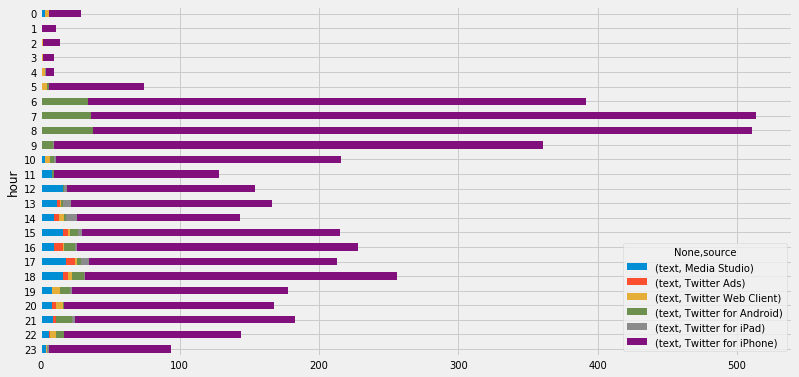

In [70]:
# tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
#     index='hour', columns=['source_clean'], aggfunc='count')

tweetsPerHour = tweets[['source', 'hour', 'text']].pivot_table(
    index='hour', columns=['source'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

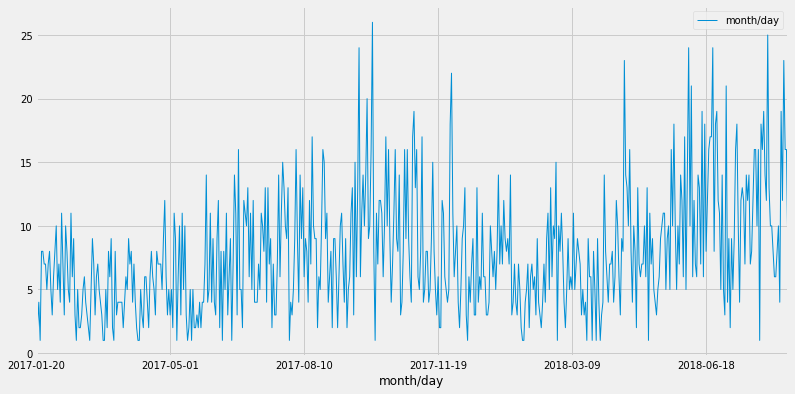

In [78]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
# tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,100), fontsize=8)
tweetsPerDay.plot(kind='line', linewidth=1.0)

In [19]:
tweetsPerDay.describe()

,month/day
count,558.000000
mean,7.792115
std,4.681582
min,1.000000
25%,4.000000
50%,7.000000
75%,10.000000
max,26.000000


## Tweets per day of week

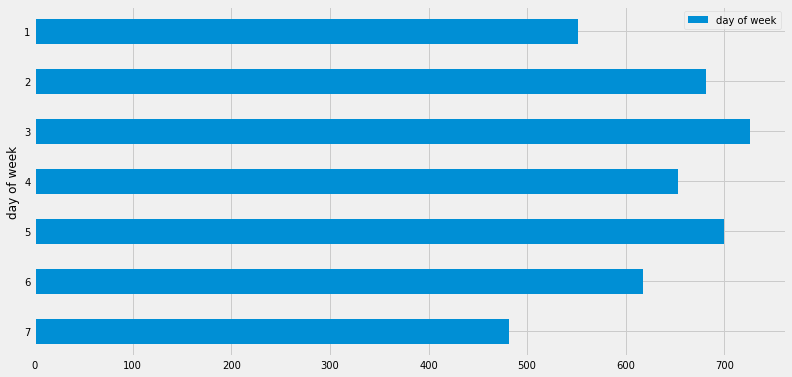

In [79]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')
# tweetsPerDayOfWeek.plot(kind='bar')

## Tweets per month

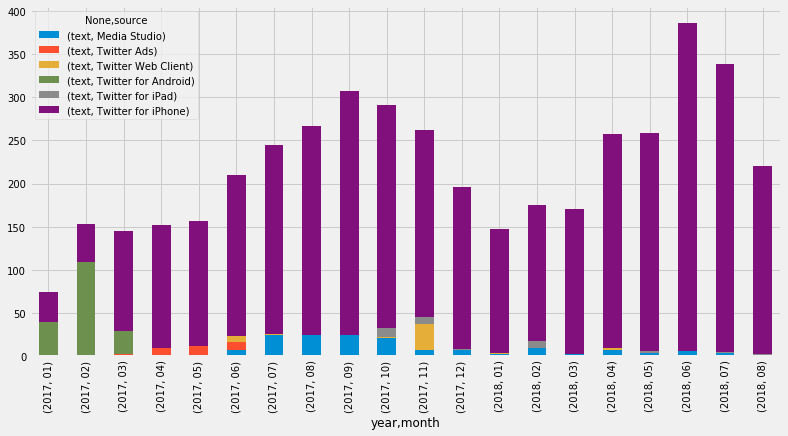

In [80]:
baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

tweetsPerMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')
tweetsPerMonth = tweetsPerMonth.reindex_like(baseMonth)
# tweetsPerMonth.iloc[::-1].plot(kind='bar', stacked=True)
tweetsPerMonth.plot(kind='bar', stacked=True)

## Tweets per week

**IMPORTANT CAVEATS:**
- Weeks (2017, 53) and (2018, 1) might be the same week
- The way we're handling weekly data assumes that Trump tweets at least once per week -- which, so far, has held true. But if there's ever a week where he _doesn't_ tweet, then that could introduce a problem with the rendered charts. (The bar/week won't appear in the chart, and it might not be obvious that it's missing.)

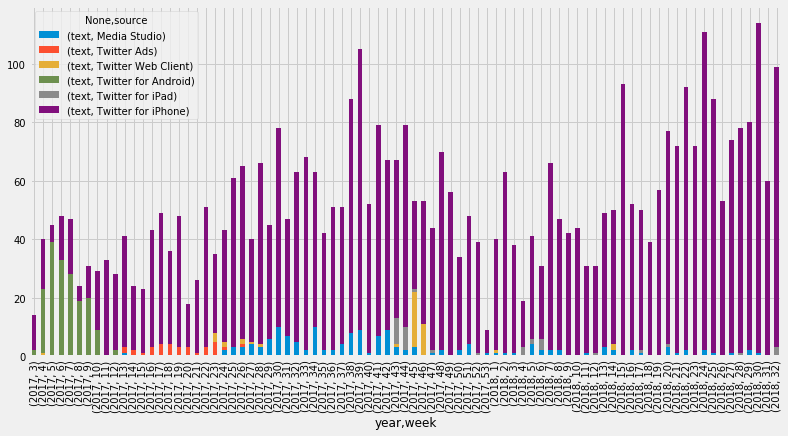

In [81]:
# tweetsPerWeek = tweets[['source', 'week', 'text']].pivot_table(index='week', columns=['source'], aggfunc='count')
tweetsPerWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [17]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-04-13 19:36:27,-0.9749,DOJ just issued the McCabe report - which is a...
2018-04-13 12:01:47,-0.9742,James Comey is a proven LEAKER &amp; LIAR. Vir...
2017-12-30 22:36:41,-0.9736,"I use Social Media not because I like to, but ..."
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2018-07-29 19:35:14,-0.9722,There is No Collusion! The Robert Mueller Rigg...


In [18]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2018-04-09 00:43:27,0.9899,Congratulations to Patrick Reed on his great a...
2018-06-16 13:12:14,0.9834,"My supporters are the smartest, strongest, mos..."
2018-07-10 10:59:30,0.9826,"Thank you to all of my great supporters, reall..."
2018-07-03 23:19:35,0.9816,"Thank you, @WVGovernor Jim Justice, for that w..."
2018-06-15 11:06:28,0.9813,Thank you for all of the compliments on gettin...


In [19]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-12-31 23:43:04,53,0.8968,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
2017-12-31 22:18:20,53,0.8915,As our Country rapidly grows stronger and smar...
2017-12-31 13:36:32,53,0.8903,Why would smart voters want to put Democrats i...
2017-12-31 19:06:52,53,0.8862,"What a year it’s been, and we're just getting ..."
2017-12-31 13:26:29,53,0.7959,"If the Dems (Crooked Hillary) got elected, you..."
2017-12-31 18:36:28,53,0.6114,My deepest condolences to the victims of the t...
2017-12-31 04:46:21,53,0.0000,“Trump Rally: Stocks put 2017 in the record bo...
2017-12-31 13:03:29,53,-0.6800,Big protests in Iran. The people are finally g...
2017-12-31 22:00:21,53,-0.6927,"Iran, the Number One State of Sponsored Terror..."


## By month

### Average

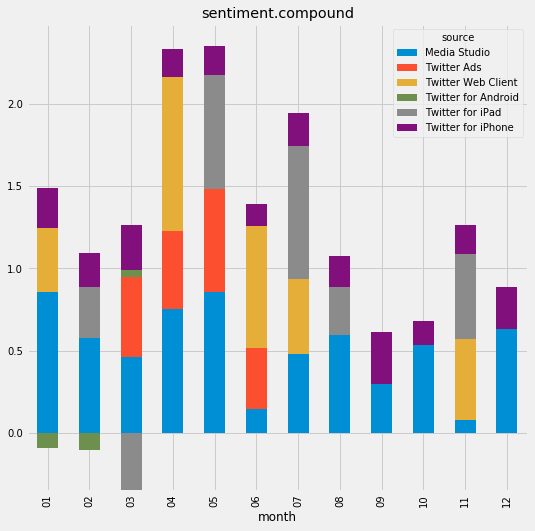

In [20]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'month', field]].pivot_table(index='month', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

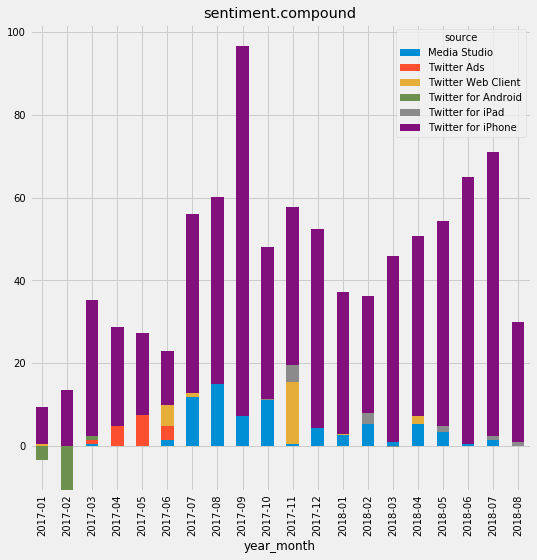

In [93]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_month', field]].pivot_table(index='year_month', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

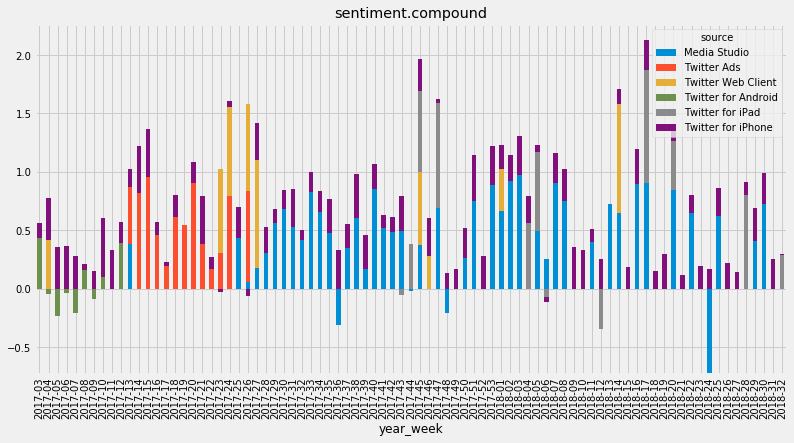

In [49]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

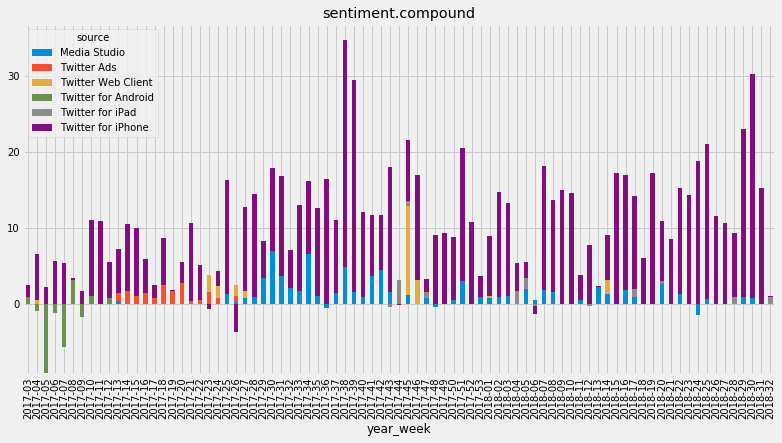

In [50]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source', 'year_week', field]].pivot_table(index='year_week', columns='source', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

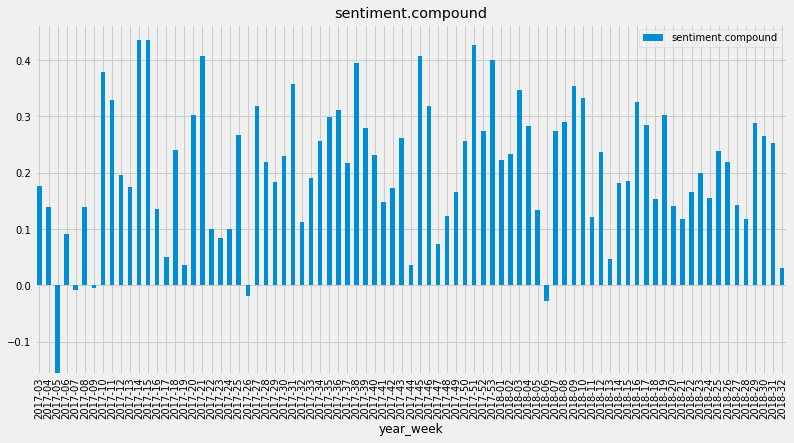

In [51]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['year_week', field]].groupby('year_week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

In [ ]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

NOTE: Doesn't work with updated dataset (8/14/2018)

In [ ]:
# tweets['user.followers_count'].plot()

In [ ]:
# tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [ ]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
# sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

In [ ]:
df_sortedSentimentPerTweet = sortedSentimentPerTweet.reset_index()
df_sortedSentimentPerTweet['text-encoded'] = df_sortedSentimentPerTweet['text'].apply(encodeText)
df_sortedSentimentPerTweet = df_sortedSentimentPerTweet.drop('text', axis=1)
df_sortedSentimentPerTweet.to_csv('output/df_sortedSentimentPerTweet.csv')

# Text analysis

Common words.

In [52]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/AHurt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,great,908,b'great'
1,&amp;,704,b'&amp;'
2,’,431,b''
3,!,411,b'!'
4,-,393,b'-'
5,",",363,"b','"
6,.,346,b'.'
7,people,333,b'people'
8,big,293,b'big'
9,fake,292,b'fake'


# Specific text searches

In [51]:
from IPython.display import display, Markdown

tweetsEnc = tweets.reset_index()

def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweetsEnc[tweetsEnc['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweetsEnc) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    
    # set up the base data frame for indexing purposes
    baseWeek = tweets[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    baseMonth = tweets[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

    # set up the filtered data frame
    analyzedByWeek = filtered[['source', 'year', 'week', 'text']].pivot_table(index=['year', 'week'], columns=['source'], aggfunc='count')
    analyzedByMonth = filtered[['source', 'year', 'month', 'text']].pivot_table(index=['year', 'month'], columns=['source'], aggfunc='count')

    # adjust the filtered data frame to use the index from the base data frame
    analyzedByWeek = analyzedByWeek.reindex_like(baseWeek)
    analyzedByMonth = analyzedByMonth.reindex_like(baseMonth)
    
    # output filtered csv
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))

    # spit out the plot
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()

    analyzedByMonthPlot = analyzedByMonth.plot(kind='bar', stacked=True, title='{0} by month'.format(search))
    plt.show()

#     analyzedByDay = filtered[['source', 'month/day', 'text']].pivot_table(index='month/day', columns=['source'], aggfunc='count')
#     analyzedByDay = analyzedByDay.reindex(range(tweetsEnc['month/day'].min(), tweetsEnc['month/day'].max())).fillna(0)
#     analyzedByDay = analyzedByDay.reindex(tweetsEnc['month/day']).fillna(0)

#     analyzedByMonth = filtered[['source', 'year_month', 'text']].pivot_table(index='year_month', columns='source', aggfunc='count')
#     analyzedByMonth = analyzedByMonth.reindex(range(tweetsEnc['year_month'].min(), tweetsEnc['year_month'].max())).fillna(0)
#     analyzedByMonth = analyzedByMonth.reindex(tweetsEnc['year_month']).fillna(0)
#     analyzedByMonthPlot = analyzedByMonth.plot(kind='bar', stacked=True, title='{0} by month'.format(search)) 
#     plt.show()

#     analyzedByHour = filtered[['source', 'hour', 'text']].pivot_table(index='hour', columns='source', aggfunc='count')
#     analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
#     analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
#     analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
#     plt.show()

#     display(Markdown('### The Tweets'))
#     for i, row in filtered.iterrows():
#         display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [52]:
# tweetsEnc

## Search: _collusion_

Number of Tweets: 96

Percent of all Tweets: 2.21%

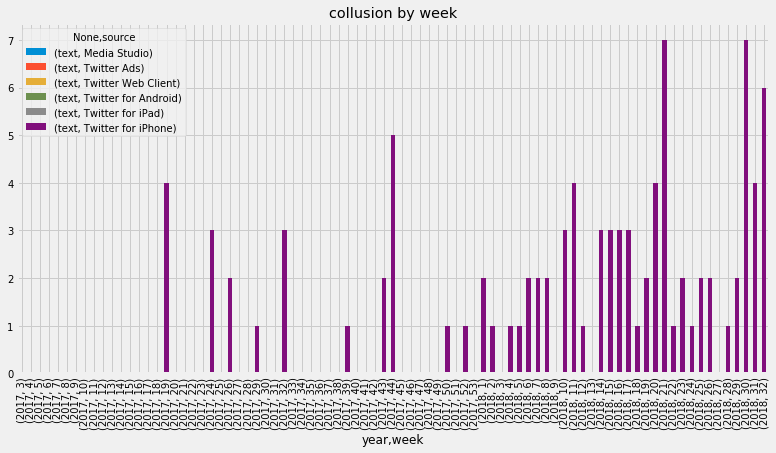

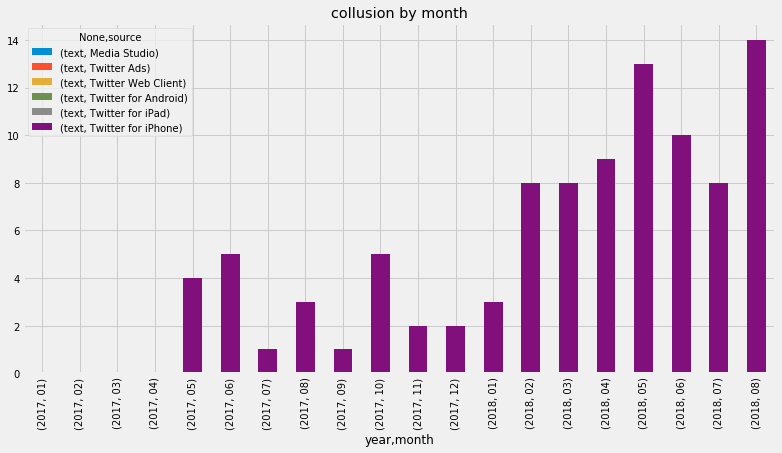

---

## Search: _russia_

Number of Tweets: 233

Percent of all Tweets: 5.36%

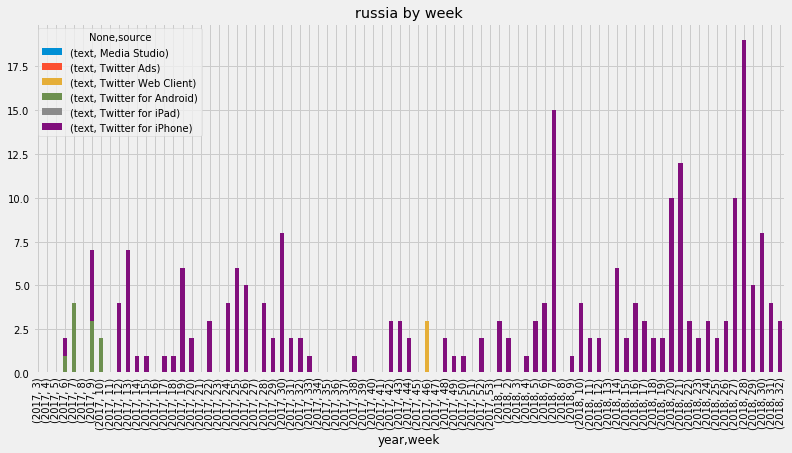

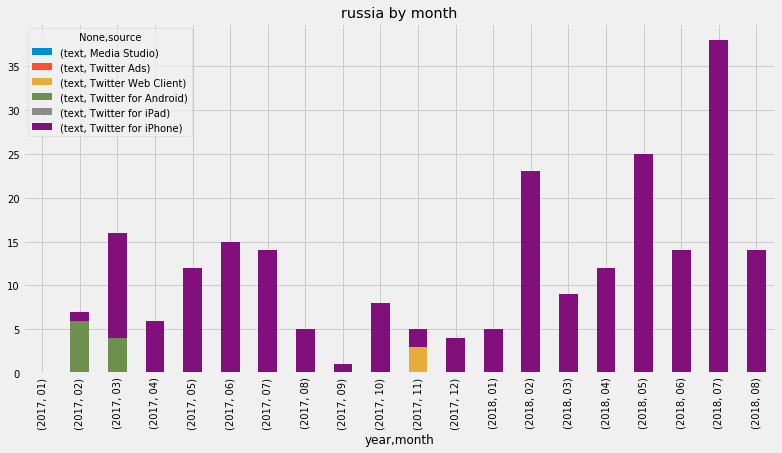

---

## Search: _witch hunt_

Number of Tweets: 111

Percent of all Tweets: 2.55%

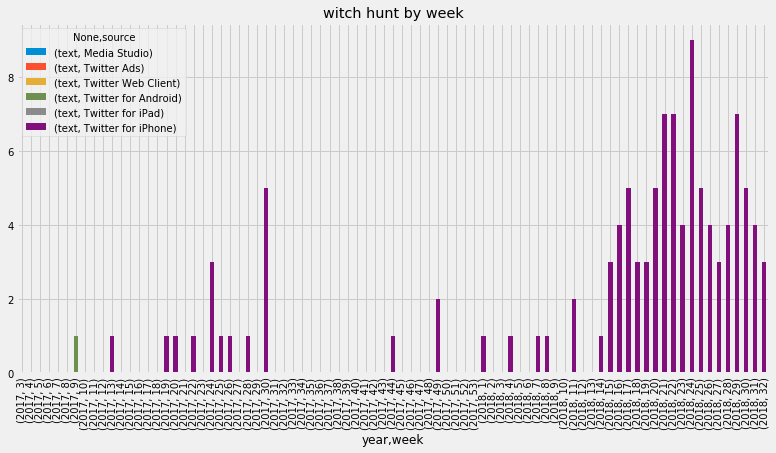

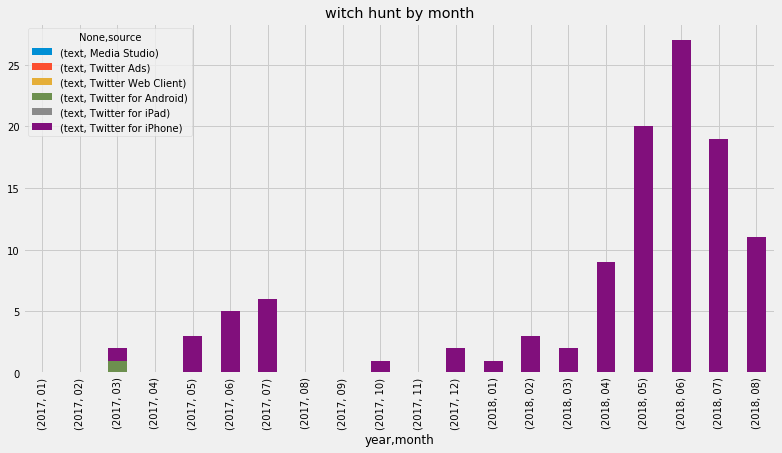

---

## Search: _mueller_

Number of Tweets: 33

Percent of all Tweets: 0.76%

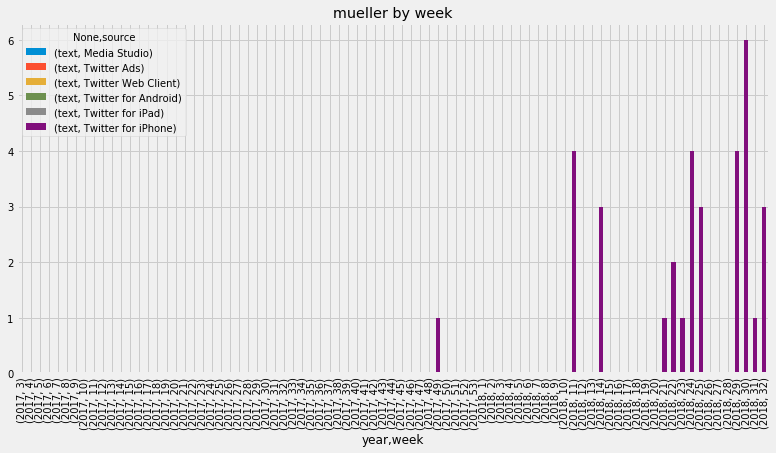

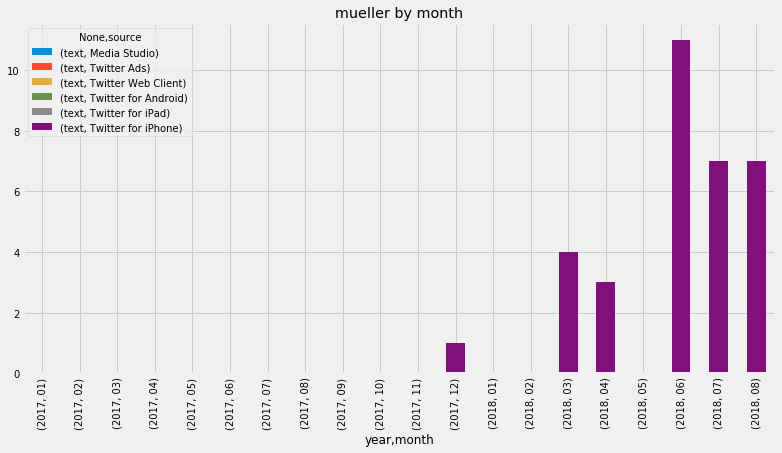

---

## Search: _sessions_

Number of Tweets: 19

Percent of all Tweets: 0.44%

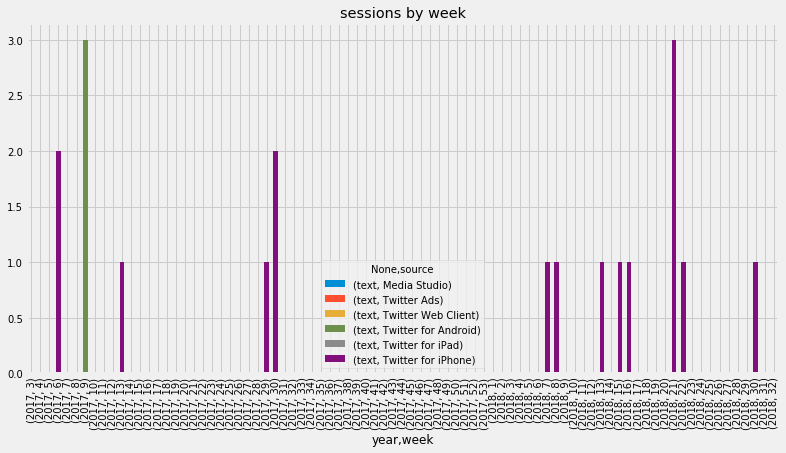

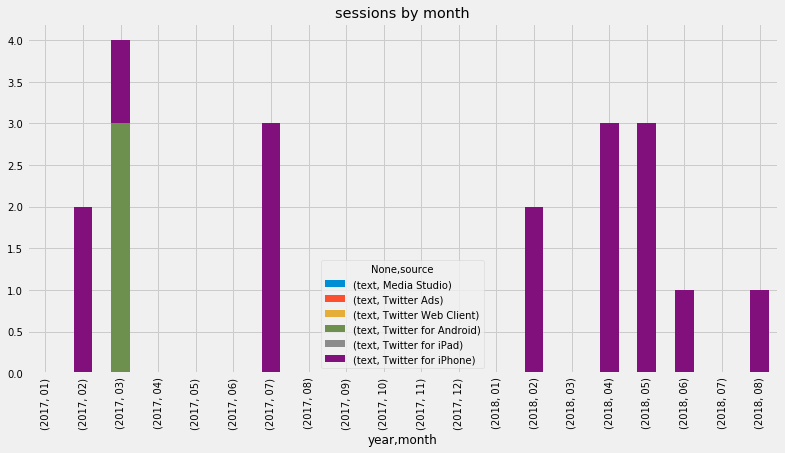

---

## Search: _justice_

Number of Tweets: 77

Percent of all Tweets: 1.77%

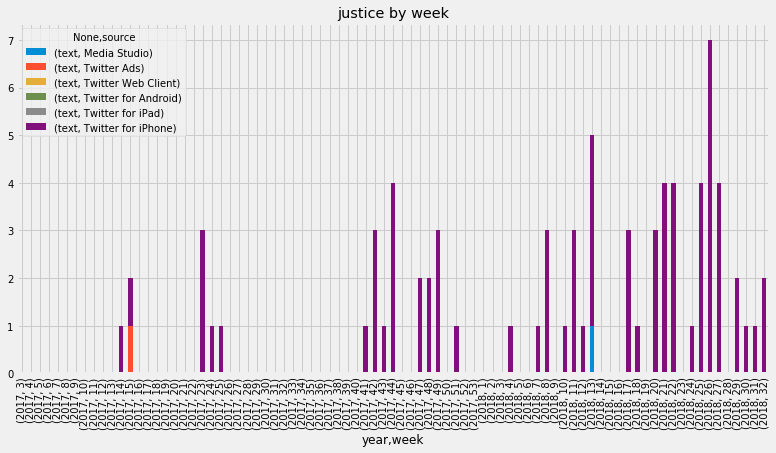

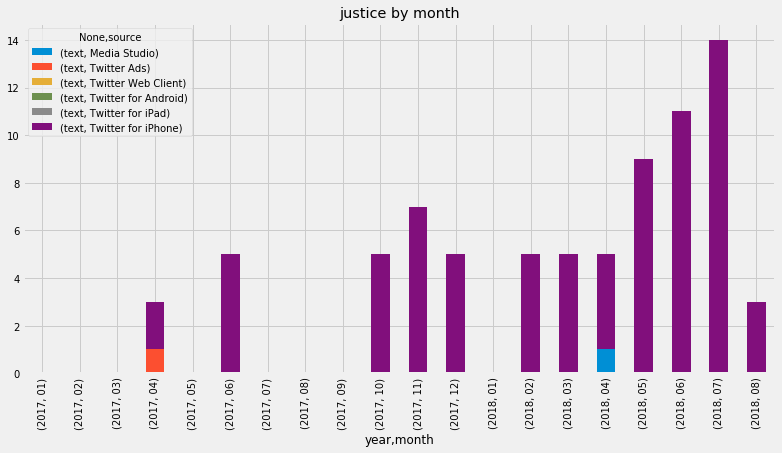

---

## Search: _fake news_

Number of Tweets: 252

Percent of all Tweets: 5.80%

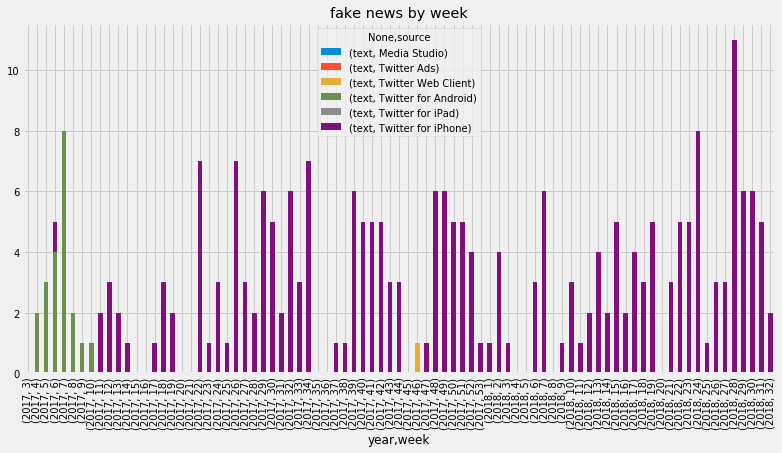

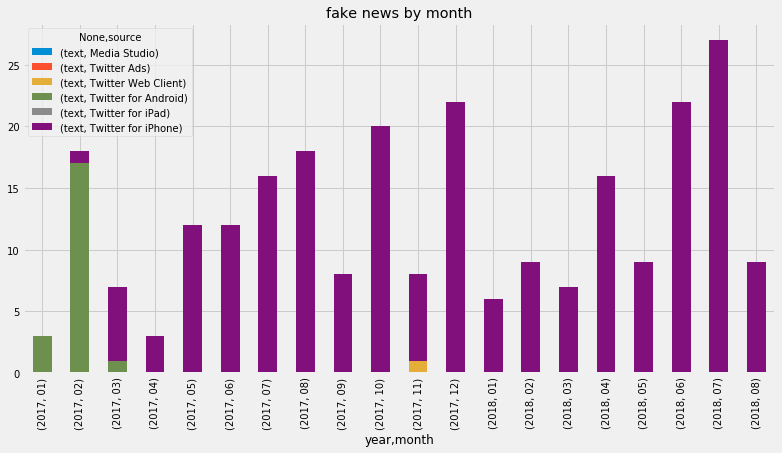

---

In [53]:
searches = [ 'collusion', 'russia', 'witch hunt', 'mueller', 'sessions', 'justice', 'fake news' ]
for search in searches:
    analyzeText(search)